# Random Forest To Predict Stock Return

In [162]:
import yfinance as yf 
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

In [163]:
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(3650)
prediction_duration = 10
# start_date = None
# end_date=None
stock_name='TCS.NS'
#stock_name='SPY'
stock = yf.Ticker(stock_name).history( start=start_date, end=end_date, auto_adjust=False)

In [164]:
training_data = stock[['Adj Close']]
training_data=training_data.rename({'Adj Close':'close'}, axis =1)
training_data ['high']= stock['High']
training_data ['low']= stock['Low']
training_data ['open']= stock['Open']
training_data ['volume']= stock['Volume']

In [165]:
#sm = training_data.ta.sma(append= True)

In [166]:
training_data.dropna()

,close,high,low,open,volume
Date,,,,,
2013-09-26 00:00:00+05:30,788.302673,987.049988,967.549988,977.400024,4919704
2013-09-27 00:00:00+05:30,790.412537,980.974976,968.724976,971.549988,1784666
2013-09-30 00:00:00+05:30,782.175964,980.924988,960.000000,977.000000,1987350
2013-10-01 00:00:00+05:30,790.798157,977.424988,958.349976,966.000000,1591994
2013-10-03 00:00:00+05:30,821.451294,1018.450012,980.200012,985.900024,4672354
...,...,...,...,...,...
2023-09-15 00:00:00+05:30,3598.300049,3607.350098,3562.449951,3567.850098,2952897
2023-09-18 00:00:00+05:30,3606.149902,3619.300049,3575.250000,3580.050049,1395753
2023-09-20 00:00:00+05:30,3606.050049,3625.000000,3580.000000,3580.000000,1649396


In [167]:
training_data.ta.strategy('momentum')

In [168]:
#rs =training_data.ta.rsi(append= True)

In [169]:
df = training_data

In [170]:
df["Ret"] = df["close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"

In [171]:
ret_fieldi=f"Ret{prediction_duration}_i"
ret_field=f"Ret{prediction_duration}"
df[ ret_fieldi] = df[name].rolling(prediction_duration).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df[ret_field] = df[ret_fieldi].shift(-prediction_duration)
df["Output"] = df[ret_field].apply(lambda x :1 if  x > 0 else -1 )
df["Output"] = df["Output"].astype(int)
del df[ret_field]
#df = df.dropna()
#df.tail(10)

### Input Preparation 

In [172]:
df=df.fillna(0)
del df['BR_26']

In [173]:
X= df.iloc[:,6:-3]
y = df.iloc[:,-1]
classes = [1,-1]

In [174]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=.2,shuffle=False)

### Model 

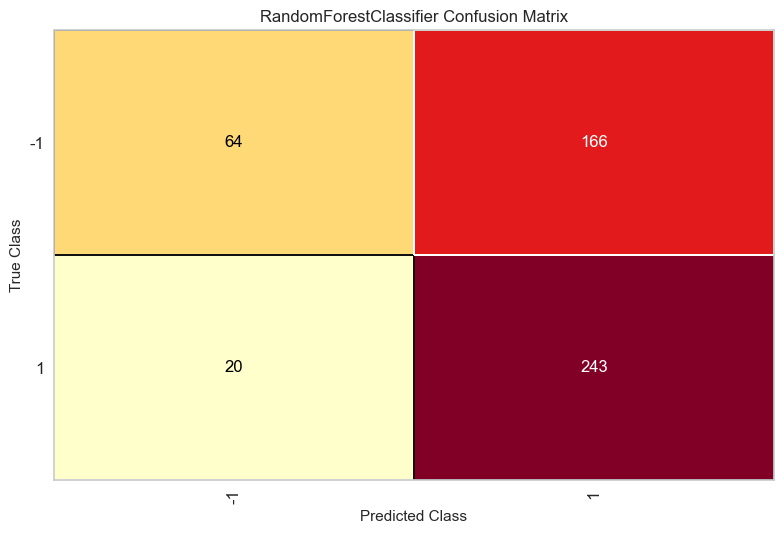

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [175]:
# The ConfusionMatrix visualizer taxes a model
model =RandomForestClassifier()
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [176]:
classifier = RandomForestClassifier()

In [177]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [178]:
classifier.score(X,y)

0.924512987012987

In [179]:
y_pred = classifier.predict(X)

In [180]:
confusion_matrix(y, y_pred)

array([[ 913,  159],
       [  27, 1365]])

In [181]:
y_pred= classifier.predict(X_test)

In [182]:
cm = confusion_matrix(y_test, y_pred)

In [183]:
from sklearn.metrics import accuracy_score,f1_score,recall_score
recall_score(y_test, y_pred)

0.8973384030418251

In [184]:
importances = classifier.feature_importances_

In [185]:
np.argmax(importances)

64

In [186]:
X.columns[65]

'TRIXs_30_9'

In [187]:
X['TRIXs_30_9']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2459    0.084993
2460    0.084837
2461    0.085315
2462    0.086397
2463    0.088078
Name: TRIXs_30_9, Length: 2464, dtype: float64

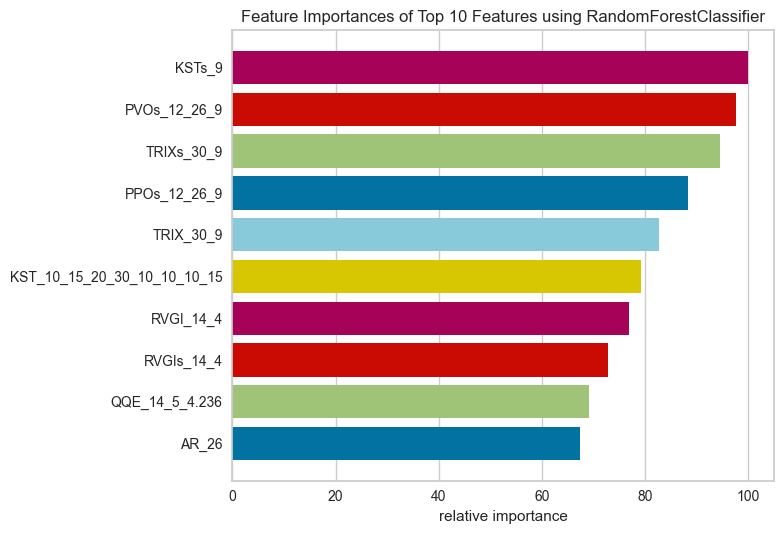

<Axes: title={'center': 'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [188]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
model = RandomForestClassifier()
viz = FeatureImportances(model, topn = 10)
viz.fit(X, y)
viz.show()

In [189]:
classifier = RandomForestClassifier()

In [190]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [191]:
X_test

,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,AR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,...,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14
1971,108.565555,49.815012,-0.003073,-1.635932,111.683137,-146.274320,-0.603863,-5.516187,7.803689,1.112162,...,-46.479429,-39.761893,1.744036,6.596714,0.323488,0.312166,25.601840,37.927439,-0.506310,-138.337023
1972,79.910859,35.064201,-0.008998,-3.606435,111.499824,-134.101791,-0.384929,-5.515463,3.870620,-0.274615,...,-47.925718,-45.532781,1.744036,3.200510,0.322357,0.315624,22.494411,35.722721,-3.037113,-144.353921
1973,41.103222,14.586703,-0.021605,-2.565513,99.653008,-142.508646,-0.551088,-5.527582,-6.336875,-1.852551,...,-47.911420,-47.438855,1.744036,1.744036,0.319806,0.317975,18.225204,33.223076,-5.966949,-161.043315
1974,9.911455,0.509246,-0.011312,-1.574048,102.219264,-114.684171,0.810996,-5.532698,3.381080,-2.622695,...,-47.599573,-47.812237,5.291383,2.926485,0.316381,0.319225,15.905728,30.749169,-4.316738,-137.401483
1975,-1.623389,-3.214504,0.003266,-0.933139,104.696693,-35.819864,1.831149,-5.523716,15.023548,-2.985415,...,-38.316299,-44.609097,20.356683,9.130701,0.312665,0.319442,15.653594,28.592658,-2.189847,-116.504099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,110.543236,36.636861,0.046552,0.678170,93.398321,134.550657,-0.054223,-5.447969,42.649525,8.527215,...,90.931314,92.124415,91.487340,93.616686,0.086182,0.084993,25.401130,11.891338,66.050340,-3.431946
2460,130.942948,51.106408,0.046914,0.592505,100.104443,116.510579,-0.431643,-5.446345,43.951091,9.872877,...,92.325862,91.366894,94.371047,92.722029,0.088880,0.084837,28.406079,14.250587,65.481840,-4.770593
2461,139.300017,63.962506,0.045050,0.578890,107.481800,98.152339,-0.705142,-5.448355,43.906351,10.674907,...,95.020699,92.759292,99.030998,94.963129,0.092039,0.085315,30.790015,16.613362,66.806105,-6.735363
2462,135.200301,72.652896,0.037470,-0.042208,102.143360,61.242794,-1.171202,-5.457842,34.548044,11.175004,...,91.230558,92.859039,93.371209,95.591085,0.095343,0.086397,31.455539,18.733673,67.920556,-14.802371


In [192]:
y_pred = classifier.predict(X_test)

In [193]:
cm = confusion_matrix(y_test, y_pred)

In [194]:
cm

array([[ 76, 154],
       [ 34, 229]])

In [195]:
from sklearn.metrics import r2_score

In [196]:
r2_score(y_test, y_pred)

-0.5322202016862292

In [197]:
classifier = RandomForestClassifier()

In [198]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [199]:
#classifier.fit(X_train,y_train)

### Predictive Performance

In [200]:
y_test.shape

(493,)

In [201]:
type(y_pred[0])

numpy.int64

In [202]:
type(1)

int

In [203]:
cm = confusion_matrix(y_test, y_pred)

In [204]:
cm

array([[ 76, 154],
       [ 34, 229]])

In [205]:
y_pred=classifier.predict(X_test)
y_test

1971   -1
1972   -1
1973   -1
1974   -1
1975   -1
       ..
2459   -1
2460   -1
2461   -1
2462   -1
2463   -1
Name: Output, Length: 493, dtype: int64

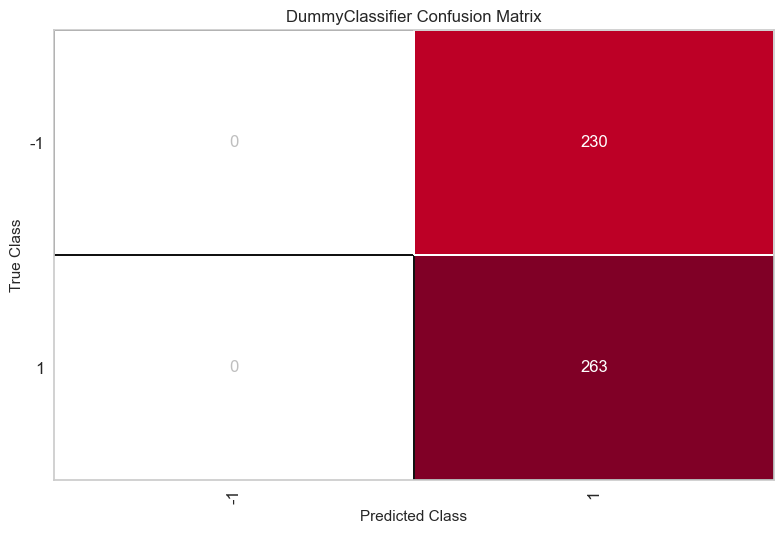

<Axes: title={'center': 'DummyClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [206]:
dummy_model = DummyClassifier(strategy="most_frequent")
cm =ConfusionMatrix(dummy_model)
cm.fit(X_train, y_train)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)
# How did we do?
cm.show()

/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


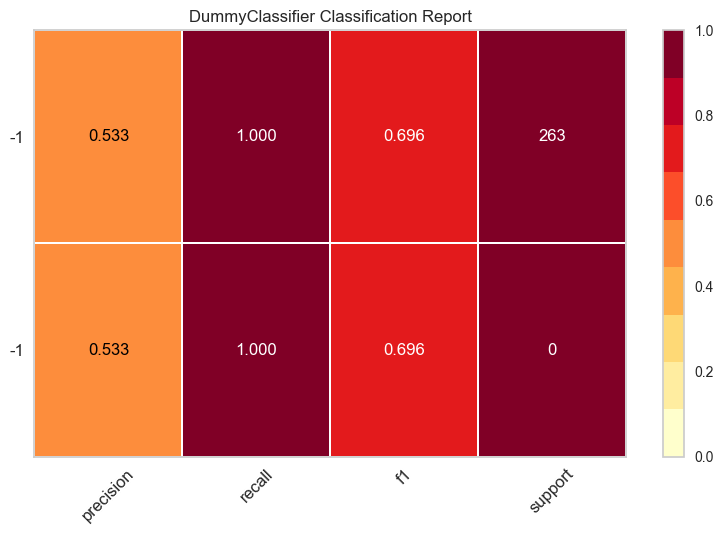

<Axes: title={'center': 'DummyClassifier Classification Report'}>

In [207]:
visualizer = ClassificationReport(dummy_model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


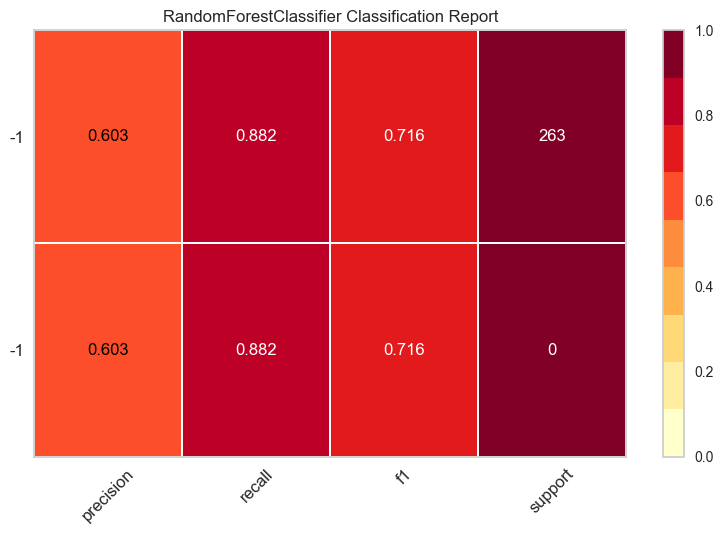

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [208]:
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

In [209]:
df['Pred'] = model.predict(df[X.columns])
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_79742/1993079715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 12319.929735783782 %
Strat Return = 271092.1637437747 %
Buy and Hold Return = 357.14038835818707 %


In [210]:
df = df.dropna()

In [211]:
ret=df.CumRet_L
ret.mean()/ret.std()

0.8701395691017948

In [212]:
ret=df.bhRet
ret.mean()/ret.std()

1.1879588721611907

In [213]:
ret=df.CumRet
ret.mean()/ret.std()

0.7089238288563527

In [214]:
df['Pred'] = dummy_model.predict(df[ X.columns])
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_79742/3819697979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 355.92013478794826 %
Strat Return = 355.92013478794826 %
Buy and Hold Return = 357.14038835818707 %


In [215]:
df

,Date,close,high,low,open,volume,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,...,Ret10_i,Output,Pred,Positions,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
1,2013-09-27 00:00:00+05:30,790.412537,980.974976,968.724976,971.549988,1784666,0.000000,0.000000,0.000000,-14.786731,...,0.000000,1,1,1,NaN,NaN,NaN,NaN,NaN,0.002676
2,2013-09-30 00:00:00+05:30,782.175964,980.924988,960.000000,977.000000,1987350,0.000000,0.000000,0.000000,-9.310593,...,0.000000,1,1,1,-0.010421,1.0,-0.010421,-0.010421,-0.010421,-0.007772
3,2013-10-01 00:00:00+05:30,790.798157,977.424988,958.349976,966.000000,1591994,0.000000,0.000000,0.000000,-9.184888,...,0.000000,1,1,1,0.011023,1.0,0.011023,0.000488,0.000488,0.003166
4,2013-10-03 00:00:00+05:30,821.451294,1018.450012,980.200012,985.900024,4672354,0.000000,0.000000,0.000000,-4.299313,...,0.000000,1,1,1,0.038762,1.0,0.038762,0.039269,0.039269,0.042051
5,2013-10-04 00:00:00+05:30,825.103027,1034.500000,1013.474976,1016.000000,1934032,0.000000,0.000000,0.000000,-9.079513,...,0.000000,1,1,1,0.004445,1.0,0.004445,0.043889,0.043889,0.046683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2023-09-15 00:00:00+05:30,3598.300049,3607.350098,3562.449951,3567.850098,2952897,110.543236,36.636861,0.046552,0.678170,...,0.063478,-1,1,1,0.010744,1.0,0.010744,3.552433,3.552433,3.564617
2460,2023-09-18 00:00:00+05:30,3606.149902,3619.300049,3575.250000,3580.050049,1395753,130.942948,51.106408,0.046914,0.592505,...,0.054025,-1,1,1,0.002182,1.0,0.002182,3.562364,3.562364,3.574575
2461,2023-09-20 00:00:00+05:30,3606.050049,3625.000000,3580.000000,3580.000000,1649396,139.300017,63.962506,0.045050,0.578890,...,0.050822,-1,1,1,-0.000028,1.0,-0.000028,3.562238,3.562238,3.574449
2462,2023-09-21 00:00:00+05:30,3585.300049,3605.000000,3528.000000,3588.550049,2004073,135.200301,72.652896,0.037470,-0.042208,...,0.044904,-1,1,1,-0.005754,1.0,-0.005754,3.535986,3.535986,3.548126


In [216]:
ret=df.CumRet_L
ret.mean()/ret.std()

1.1862792168369827

In [217]:
ret=df.CumRet
ret.mean()/ret.std()

1.1862792168369827

In [218]:
ret=df.bhRet
ret.mean()/ret.std()

1.1879588721611907